In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import copy
import json
import random
import numpy as np
import pandas as pd

In [4]:
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tqdm import trange

In [6]:
from nas_environment import Environment

In [7]:
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import sklearn.metrics.pairwise
from scipy.spatial import distance
from argparse import Namespace
import pickle as pkl

In [8]:
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval

# Set-up the environment

In [9]:
precomputed_logs_path = 'train_logs_single_run/'

In [31]:
scoring_metric_path = './release_results/NLP/PTB/SINGLE/WEIGHT_1e-05_0.001/BS256/'
data_file = open('{}Data'.format(scoring_metric_path),'rb')
data = pkl.load(data_file)
score = data["score"]
data_file.close()

In [32]:
ind_score={}
# Prepare dictionary of indices for multiple runs tests
file_list=os.listdir(precomputed_logs_path)
for ind in range(len(file_list)):
    file = file_list[ind]
    log = json.load(open(precomputed_logs_path + file, 'r'))
    args = Namespace(**log)
    if ~np.isnan(score[ind]):
        ind_score[ind]=score[ind]
    else:
        ind_score[ind]=0

In [33]:
env = Environment(precomputed_logs_path)

In [34]:
len(env._logs)

14322

In [35]:
search_set = env.get_precomputed_recepies()

In [36]:
alg_results = {}

# Random seach

In [37]:
def run_random_search(max_trained_models=1000, 
                      zero_cost_warmup=0):
    
    best_tests = [np.inf]
    pool = []   # (validation, spec) tuples
    num_trained_models = 0
    selected_inds = []
    
    # fill the initial pool
    if zero_cost_warmup > 0:
        zero_cost_pool = []
        for j in range(zero_cost_warmup):
            cur_ind = np.random.choice(np.setdiff1d(np.arange(len(search_set)), np.array(selected_inds)), 
                                       1, replace=False)[0]
            selected_inds.append(cur_ind)
            zero_cost_pool.append((ind_score[cur_ind], cur_ind))
            zero_cost_pool = sorted(zero_cost_pool, key=lambda i:i[0], reverse=True)
    for i in range(max_trained_models):
        if i < zero_cost_warmup:
            spec_ind = zero_cost_pool[i][1]
        else:
            spec_ind = np.random.choice(np.setdiff1d(np.arange(len(search_set)), np.array(selected_inds)), 
                                       1, replace=False)[0]
        # Retrieve test loss
        env.reset()
        env.simulated_train(search_set[spec_ind], 50)
        test_acc = env.get_test_loss_of_the_best_validated_architecture()
        
        if test_acc < best_tests[-1]:
            best_tests.append(test_acc)
        else:
            best_tests.append(best_tests[-1])
            
    best_tests.pop(0)
    
    return best_tests

In [38]:
num_rounds = 100
length = 300
rand, rand_warmup = [], []
np.random.seed(21)
for _ in trange(num_rounds):
    rand_best_tests = run_random_search(max_trained_models=length)
    rand.append(rand_best_tests)
    rand_warmup_best_tests = run_random_search(max_trained_models=length, zero_cost_warmup=3000)
    rand_warmup.append(rand_warmup_best_tests)

100%|█████████████████████████████████████████| 100/100 [06:39<00:00,  4.00s/it]


In [39]:
def plot_experiment(exp_list, title, filename):
    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(111)
    def plot_exp(exp, label):
        exp = np.array(exp) 
        q_75 = np.quantile(exp, .75, axis=0)
        q_25 = np.quantile(exp, .25, axis=0)
        median = np.median(exp, axis=0)
        ax.plot(median, label=label)
        ax.fill_between(range(len(q_25)), q_25, q_75, alpha=0.2)
    for exp,ename in exp_list:
        plot_exp(exp, ename)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)
    
    plt.grid()
    plt.xlabel('Trained Models', fontsize = 22)
    plt.ylabel('Test Perplexity', fontsize = 22)
    plt.ylim(4.55,5) #89,92   44,47    70,73.6
    plt.legend(fontsize = 16)
    plt.title(title, fontsize = 22)
    plt.savefig(filename,
                bbox_inches='tight', 
                dpi=300,
                format='pdf')
    plt.show()

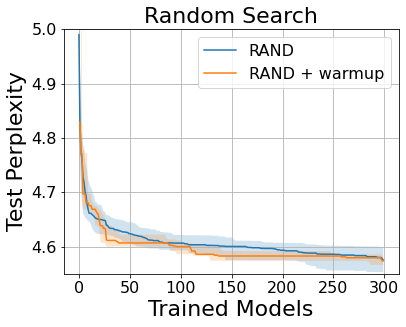

In [40]:
results_dir = './release_results'
save_dir = '{}/NLP/RE/'.format(results_dir)
os.makedirs(save_dir, exist_ok=True)
filename=save_dir + 'RandomSearch_Len300_Rounds100_WarmUp3000.pdf'
plot_experiment([(rand,'RAND'), (rand_warmup,'RAND + warmup')], 'Random Search', filename)

# Evolutionary search

In [41]:
df_recepie_vectors = pd.read_csv('data/doc2vec_features.csv').set_index('recepie_id')

In [42]:
search_set_recepie_ids = np.array(env.get_recepie_ids())

In [43]:
X = df_recepie_vectors.loc[search_set_recepie_ids].values
axes_bounds = (np.min(X, axis=0), np.max(X, axis=0))

In [44]:
def random_spec():
    return random.choice(list(idx_to_spec.values()))
##

# Attempt several mutations (some might give child==parent)
def find_child(X, parent, axes_bounds):
    for std in [0.5, 1.0, 2.0, 4.0, 8.0]:
        e_new = mutate_embedded(X[parent], std, axes_bounds)
        child = find_closest(X, e_new)
        if child != parent:
            # Stop when we find a child that differs from the parent
            return child
##

def find_closest(E, e):
    dists = distance.cdist([e], E, "cosine")[0]
    return np.argmin(dists)
##

def mutate_embedded(e, std=1, axes_bounds=None):
    e_new = e + np.random.randn(len(e)) * std
    if axes_bounds is not None:
        e_new = np.clip(e_new, axes_bounds[0], axes_bounds[1])
    return e_new
##

def random_combination(iterable, sample_size):
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), sample_size))
    return tuple(pool[i] for i in indices)
##

In [45]:
def run_evolution_search(max_trained_models=1000,
                         pool_size=64,
                         tournament_size=10,
                         zero_cost_warmup=0,
                         zero_cost_move=False):
    
    best_tests, best_valids = [99], [99]
    pool = []   # (validation, spec) tuples
    num_trained_models = pool_size
    selected_inds = []
    i = 0
    # create pool (either with warm up or with simulated training)
    if zero_cost_warmup > 0:
        zero_cost_pool = []
        for j in range(zero_cost_warmup):
            cur_ind = np.random.choice(np.setdiff1d(np.arange(len(search_set)), np.array(selected_inds)), 
                                       1, replace=False)[0]
            selected_inds.append(cur_ind)
            zero_cost_pool.append((ind_score[cur_ind], cur_ind))
        zero_cost_pool = sorted(zero_cost_pool, key=lambda i:i[0], reverse=True)

    # omits NaN reported perplexities
    while len(pool)!=pool_size:
        if zero_cost_warmup > 0:
            spec_ind = zero_cost_pool[i][1]
        else:
            spec_ind = np.random.choice(np.setdiff1d(np.arange(len(search_set)), np.array(selected_inds)), 
                                       1, replace=False)[0]
        
        env.reset()
        env.simulated_train(search_set[spec_ind], 50)
        test_acc = env.get_test_loss_of_the_best_validated_architecture()
        val_acc = env.get_val_loss_of_the_best_validated_architecture()
        i += 1
        if ~np.isnan(test_acc):
            pool.append((val_acc, ind_score[spec_ind], spec_ind))

            if val_acc < best_valids[-1]:
                best_valids.append(val_acc)
            else:
                best_valids.append(best_valids[-1])

            if test_acc < best_tests[-1]:
                best_tests.append(test_acc)
            else:
                best_tests.append(best_tests[-1])
            
    # After the pool is seeded, proceed with evolving the population.
    while(1):
        # Pick several architectures among pool
        sample = random_combination(pool, tournament_size)
        # Select the best one based on the validation perplexity
        if zero_cost_move:
            parent = sorted(sample, key=lambda i:i[1])[-1][2]
        else:
            parent = sorted(sample, key=lambda i:i[0])[-1][2]
        
        child = find_child(X, parent, axes_bounds)
        
        env.reset()
        env.simulated_train(search_set[child], 50)
        test_acc = env.get_test_loss_of_the_best_validated_architecture()
        val_acc = env.get_val_loss_of_the_best_validated_architecture()
        num_trained_models += 1
        
        # kill the oldest individual in the population.
        pool.append((val_acc, ind_score[child], child))
        pool.pop(0)
            
        if test_acc < best_tests[-1]:
            best_tests.append(test_acc)
        else:
            best_tests.append(best_tests[-1])
            
        if val_acc < best_valids[-1]:
            best_valids.append(val_acc)
        else:
            best_valids.append(best_valids[-1])

        if num_trained_models >= max_trained_models:
            break
            
    best_tests.pop(0)
    best_valids.pop(0)
    return best_valids, best_tests

In [46]:
num_rounds = 100
length = 300
random.seed = 21
ae, ae_warmup, ae_move, ae_warmup_move = [], [], [], []
for _ in trange(num_rounds):
    ae_best_valids, ae_best_tests = run_evolution_search(max_trained_models=length)
    ae.append(ae_best_tests)
    ae_warmup_best_valids, ae_warmup_best_tests = run_evolution_search(max_trained_models=length, zero_cost_warmup=3000)
    ae_warmup.append(ae_warmup_best_tests)
    ae_move_best_valids, ae_move_best_tests = run_evolution_search(max_trained_models=length, zero_cost_move=True)
    ae_move.append(ae_move_best_tests)
    ae_move_warmup_best_valids, ae_warmup_move_best_tests = run_evolution_search(max_trained_models=length, zero_cost_move=True)
    ae_warmup_move.append(ae_warmup_move_best_tests)

100%|█████████████████████████████████████████| 100/100 [11:03<00:00,  6.64s/it]


In [47]:
def plot_experiment(exp_list, title, filename):
    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(111)
    def plot_exp(exp, label):
        exp = np.array(exp) 
        q_75 = np.quantile(exp, .75, axis=0)
        q_25 = np.quantile(exp, .25, axis=0)
        median = np.median(exp, axis=0)
        ax.plot(median, label=label)
        ax.fill_between(range(len(q_25)), q_25, q_75, alpha=0.1)
    for exp,ename in exp_list:
        plot_exp(exp, ename)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)
    
    plt.grid()
    if "Rand" in filename:
        plt.xlabel('Trained Models', fontsize = 22)
    if "Evol" in filename:
        plt.title('PTB', fontsize = 22)
    plt.ylabel('Test Perplexity', fontsize = 22)

    plt.ylim(4.55, 4.75) #89,92   44,47    70,73.6
    plt.legend(fontsize = 16)
    plt.savefig(filename,
                bbox_inches='tight', 
                dpi=300,
                format='pdf')
    plt.show()

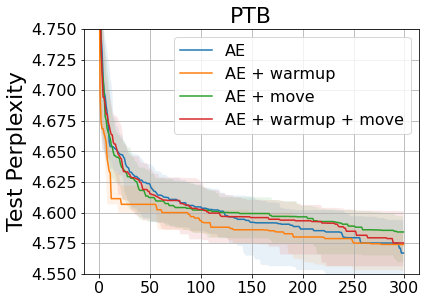

In [48]:
results_dir = './release_results'
save_dir = '{}/NLP/RE/'.format(results_dir)
os.makedirs(save_dir, exist_ok=True)
filename=save_dir + 'Evolution_Len300_Rounds100_Move.pdf'
plot_experiment([(ae,'AE'), (ae_warmup,'AE + warmup'), (ae_move,'AE + move'), (ae_warmup_move, 'AE + warmup + move')], 'Aging Evolution Search', filename)

# BayesOpt

In [81]:
df_recepie_vectors = pd.read_csv('data/doc2vec_features.csv').set_index('recepie_id')
df_recepie_vectors_lowdim = pd.read_csv('data/doc2vec_features_lowdim.csv').set_index('recepie_id')

In [83]:
search_set_recepie_ids = np.array(env.get_recepie_ids())

In [84]:
X_highdim = df_recepie_vectors.loc[search_set_recepie_ids].values
X_lowdim = df_recepie_vectors_lowdim.loc[search_set_recepie_ids].values

In [91]:
for X, alias in zip([X_highdim, X_lowdim], ['50D', '10D']):
#     if alias == '50D':
#         continue
    all_test_losses = []
    all_wall_times = []
    epochs_train = 50
    N_init = 20 # check randomly a few architectures at first
    beta = 2.0
    N = int(1.3*iters_per_round)
    train_batch = 10
    for seed in tqdm_notebook(range(rounds)):
    #for seed in tqdm_notebook(range(5)):
        np.random.seed(seed)
        env.reset()
        selected_inds = []
        test_losses = []
        wall_times = []
        X_train = []
        y_train = []
        # check a few random architectures at first
        for i in range(N_init):
            cur_ind = np.random.choice(np.setdiff1d(np.arange(len(search_set)), np.array(selected_inds)), 
                                       1, replace=False)[0]
            env.simulated_train(search_set[cur_ind], epochs_train)
            selected_inds.append(cur_ind)
            if env.get_model_status(search_set[cur_ind]) == 'OK':
                X_train.append(X[cur_ind])
                y_train.append(env.get_model_stats(search_set[cur_ind], epochs_train - 1)['val_loss'])
            test_losses.append(ind_score[cur_ind])
#             test_losses.append(env.get_test_loss_of_the_best_validated_architecture())
            wall_times.append(env.get_total_time())


        regr = BaggingRegressor(XGBRegressor(n_estimators=100, max_depth=15), 
                                n_estimators=14, max_samples=0.5, n_jobs=14)

        # train estimator and score new candidates according to the lower-confidence-bound acquisition function
        for i in range(N_init, N):
            if i % train_batch == 0:
                regr.fit(np.array(X_train), np.array(y_train))
                y_pred_mean = regr.predict(X)
                y_pred_std = np.std([e.predict(X) for e in regr.estimators_], axis=0)
                scores = y_pred_mean - beta * y_pred_std

            scores[np.array(selected_inds)] = np.inf

            cur_ind = np.argmin(scores)

            env.simulated_train(search_set[cur_ind], epochs_train)
            if env.get_model_status(search_set[cur_ind]) == 'OK':
                X_train.append(X[cur_ind])
                y_train.append(env.get_model_stats(search_set[cur_ind], epochs_train - 1)['val_loss'])
            selected_inds.append(cur_ind)
            test_losses.append(ind_score[cur_ind])
#             test_losses.append(env.get_test_loss_of_the_best_validated_architecture())
            wall_times.append(env.get_total_time())
        all_test_losses.append(test_losses)
        all_wall_times.append(wall_times)


    alg_results[f'bayes_opt_{alias}'] = {'all_test_losses':all_test_losses, 'all_wall_times':all_wall_times}

/home/gracheva/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/5 [00:00<?, ?it/s]

/home/gracheva/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/5 [00:00<?, ?it/s]

# Regularized evolution

In [141]:
def mutate_embedded(e, std=1, axes_bounds=None):
    e_new = e + np.random.randn(len(e)) * std
    if axes_bounds is not None:
        e_new = np.clip(e_new, axes_bounds[0], axes_bounds[1])
    return e_new

In [142]:
def find_closest(E, e):
    dists = distance.cdist([e], E, "cosine")[0]
    return np.argmin(dists)

In [172]:
all_test_losses = []
all_wall_times = []

train_epochs = 50
P = 20
C = int(1.3*iters_per_round)
S = 10

axes_bounds = (np.min(X, axis=0), np.max(X, axis=0))

for seed in tqdm_notebook(range(rounds)):
    np.random.seed(seed)
    env.reset()
    test_losses = []
    wall_times = []
    
    # init first P architectures
    population = []
    history = []
    for i in np.random.choice(np.arange(len(search_set)), P, replace=False):
        env.simulated_train(search_set[i], train_epochs)
        population.append(i)
        history.append(i)
#         test_losses.append(ind_score[i])
        test_losses.append(env.get_val_loss_of_the_best_validated_architecture())
        wall_times.append(env.get_total_time())
    
    attempt = 0
    valid_round = True
    while len(history) < C:
        sample = np.random.choice(population, S, replace=False)
        sample_scores = [env.get_model_stats(search_set[i], train_epochs - 1)['val_loss'] 
                         for i in sample if env.get_model_status(search_set[i]) == 'OK']
        if len(sample_scores) == 0: 
            # this is unlikely to happen, but just to make sure that the code will work anyway
            attempt += 1
            if attempt > 5:
                valid_round = False
                break
            else:
                continue
        else:
            attempt = 0
        parent = sample[np.argmin(sample_scores)]
        
        for std in [0.5, 1.0, 2.0, 4.0, 8.0]:
            e_new = mutate_embedded(X[parent], std, axes_bounds)
            child = find_closest(X, e_new)
            if child != parent:
                # stop when we find a child that differs from the parent
                break
        
        env.simulated_train(search_set[child], train_epochs)
        history.append(child)
        population = population[1:] + [child]
#         test_losses.append(ind_score[child])
        test_losses.append(env.get_test_loss_of_the_best_validated_architecture())
        wall_times.append(env.get_total_time())
    
    if valid_round:
        all_test_losses.append(test_losses)
        all_wall_times.append(wall_times)
    #break
    
alg_results['regularized_evolution'] = {'all_test_losses':all_test_losses, 'all_wall_times':all_wall_times}

/home/gracheva/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/5 [00:00<?, ?it/s]

2155702.2685120106
2339723.739474535
2529745.978885174
2727230.5250082016
2929489.749279022
3136980.270576
3344470.791872978
3559736.2810652256
3775001.770257473
3999886.158840418
4234479.404461861
4469072.650083303
4714141.614598751
4975878.0432219505
5237614.47184515
5499350.900468349
5761087.329091549
6029982.619240999
6308458.390109301
6592365.110197306
6884358.126533747
7176351.142870188
7480486.322634935
7789430.174089193
8110509.524233818
8441821.84688592
8806578.07585454
9181263.898858786
9563022.008018255
9956090.027185917
10353941.185593128
10758918.315903902
11174304.042179108
11600599.087920189
12026894.13366127
12460201.386626005
12900737.872838497
13352309.37757063
13803880.882302761
14261969.897263288
14733985.83445692
15206001.771650553
15688444.677603722
16180127.476753235
16678008.261850119
17189484.303524017
17700960.345197916
18223344.679441452
18762176.296769857
19306233.96010375
19865592.6625638
20433032.500258923
21006636.59739518
21580240.69453144
22164211.90823

9306661.308960676
9733358.678819656
10169240.525117874
10612938.379273891
11071023.158536434
11541925.576518774
12012827.994501114
12499314.512456179
12999342.079373598
13509688.077797651
14026275.405071497
14549268.558997393
15089711.48625493
15642169.878906727
16213898.646316528
16800198.692352533
17393057.134907246
17999171.221788645
18619381.153465033
19252402.51572156
19885423.877978086
20533227.772756577
21191637.59469652
21864277.58216405
22545538.591007233
23245627.88519764
23958284.217092514
24680694.147727013
25420638.899035692
26175470.156918526
26930301.41480136
27691478.466439486
28463410.84810996
29235343.229780436
30016364.83086562
30797386.431950808
31590620.691758633
32394207.964031935
33202204.44232869
34010200.92062545
34822212.850910425
35644726.461295605
36484029.18971825
37323331.91814089
38179101.15950513
39036044.15563178
39892987.15175843
40759936.88313866
41651588.41352415
42543239.943909645
43448843.06750584
44368177.16438341
45287511.26126099
46206845.358138

# TPE

In [95]:
def objective_vec(vec):
    
    # The most similar vector in X:
    distances = distance.cdist([vec], X, "cosine")[0]
    #distances = np.linalg.norm(X - vec.reshape(1, -1), axis=1)
    recepie_id = np.argmin(distances)
    recepie = search_set[recepie_id]


    env.simulated_train(recepie, epochs_train)
    test_losses.append(ind_score[recepie_id])
#     test_losses.append(env.get_test_loss_of_the_best_validated_architecture())
    wall_times.append(env.get_total_time())


    if env.get_model_status(recepie) == 'OK':
        result = env.get_model_stats(recepie, epochs_train - 1)['val_loss']
    else:
        result = 10
    return result

In [96]:
def objective_dict(vec_as_dict):
    
    vec = np.zeros(50)
    for k, v in vec_as_dict.items():
        vec[int(k)] = v
    
    return objective_vec(vec)

In [97]:
X = X_highdim

In [98]:
components_space = {}
for i in range(X.shape[-1]):
    min_val = X[:, i].min()
    max_val = X[:, i].max()
    components_space[i] = hp.uniform(f'component_{i}', min_val, max_val)
search_space = components_space

In [99]:
N = int(1.3*iters_per_round)

In [100]:
for epochs_train in [50]:
    all_test_losses = []
    all_wall_times = []

    for seed in tqdm_notebook(range(rounds)):
        np.random.seed(seed)
        os.environ['HYPEROPT_FMIN_SEED'] = str(seed)
        env.reset()
        test_losses, wall_times = [], []

        # minimize the objective over the space
        best = fmin(objective_dict, search_space, algo=tpe.suggest, max_evals=N,
                    verbose=False, show_progressbar=True, max_queue_len=20)
        all_test_losses.append(test_losses)
        all_wall_times.append(wall_times)

    alg_results[f'TPE_{epochs_train}_epochs'] = {'all_test_losses':all_test_losses, 'all_wall_times':all_wall_times}

/home/gracheva/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/5 [00:00<?, ?it/s]

# Plot resuls

In [169]:
legend_algs = {
#     'random_search_50_epochs': 'RS 50E',
#     'random_search_10_epochs': 'RS 10E',
#     'hyperband':'HB',
#     'bayes_opt_50D':'BO 50D',
#     'bayes_opt_10D':'BO 10D',
    'regularized_evolution':'RE',
#     'TPE_50_epochs':'TPE',
#     'SMAC[LHDesign_10D]':'SMAC'
}

In [170]:
y_opt = env.get_best_possible_test_loss()

FileNotFoundError: [Errno 2] No such file or directory: 'data/figures/benchmarks_log_y_scale.png'

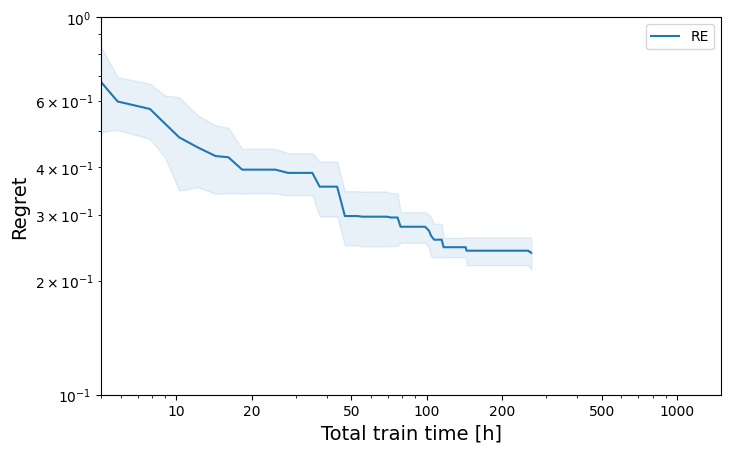

In [171]:
plt.figure(figsize=(8, 5), dpi=100)

for i, alg_name in enumerate(['regularized_evolution']):
# for i, alg_name in enumerate(['random_search_50_epochs', 'random_search_10_epochs', 'hyperband', 
#                               'bayes_opt_50D', 'bayes_opt_10D', 'regularized_evolution', 'TPE_50_epochs']):
    all_test_losses = alg_results[alg_name]['all_test_losses']
    all_wall_times = alg_results[alg_name]['all_wall_times']

    all_xs = np.array(all_test_losses)
    all_ts = np.array(all_wall_times)/3600.

    s = 1.96/np.sqrt(all_xs.shape[0])

    all_ts_mean = all_ts.mean(axis=0)

    all_ts_max = all_ts_mean + s*all_ts.std(axis=0)
    all_ts_min = all_ts_mean - s*all_ts.std(axis=0)

    all_xs_mean = np.nanmean(all_xs, axis=0)

    all_xs_max = all_xs_mean + s*np.nanstd(all_xs, axis=0)
    all_xs_min = all_xs_mean - s*np.nanstd(all_xs, axis=0)


    plt.plot(all_ts_mean, all_xs_mean - y_opt, lw=1.5, color=f'C{i}', label=legend_algs[alg_name])

    plt.fill_between(all_ts_mean, all_xs_min - y_opt, all_xs_max - y_opt, alpha=0.1, edgecolor=f'C{i}')

plt.legend()
plt.xlabel('Total train time [h]', fontsize=14)
plt.ylabel('Regret', fontsize=14)
plt.ylim([0.1, 1.0])
plt.xscale('log')
plt.yscale('log')
plt.xlim([5, 1500])
plt.xticks([10, 20, 50, 100, 200, 500, 1000]);
plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.savefig('data/figures/benchmarks_log_y_scale.png', dpi=300, bbox_inches='tight')

In [ ]:
from matplotlib import ticker

plt.figure(figsize=(8, 5), dpi=100)

for i, alg_name in enumerate(['random_search_50_epochs', 'random_search_10_epochs', 'hyperband', 
                              'bayes_opt_50D', 'bayes_opt_10D', 'regularized_evolution', 'TPE_50_epochs',
                             'SMAC[LHDesign_10D]']):
    all_test_losses = alg_results[alg_name]['all_test_losses']
    all_wall_times = alg_results[alg_name]['all_wall_times']

    all_xs = np.array(all_test_losses)
    all_ts = np.array(all_wall_times)/3600.

    s = 1.96/np.sqrt(all_xs.shape[0])

    all_ts_mean = all_ts.mean(axis=0)

    all_ts_max = all_ts_mean + s*all_ts.std(axis=0)
    all_ts_min = all_ts_mean - s*all_ts.std(axis=0)

    all_xs_mean = np.nanmean(all_xs, axis=0)

    all_xs_max = all_xs_mean + s*np.nanstd(all_xs, axis=0)
    all_xs_min = all_xs_mean - s*np.nanstd(all_xs, axis=0)

    plt.plot(np.sort(all_xs[:, -1]) - y_opt, np.linspace(0, 1, len(all_xs)), color=f'C{i}', label=legend_algs[alg_name])
plt.legend()


plt.xlabel('Final test regret', fontsize=14)
plt.ylabel('CDF', fontsize=14)
plt.savefig('data/figures/benchmarks_CDF_regret.png', dpi=300, bbox_inches='tight')